In [1]:
%load_ext autoreload
%autoreload 2

In [148]:
from os.path import join
import numpy as np
from tqdm import tqdm

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from constants import DATA_DIR, idx_to_class
from classify import STL, BoWClassifier, relevant_classes

### Dataset object

In [3]:
TRAIN_X_PATH = join(DATA_DIR, "train_X.bin")
TRAIN_y_PATH = join(DATA_DIR, "train_y.bin")

In [4]:
train_data = STL(TRAIN_X_PATH, TRAIN_y_PATH)

::::::::: Loaded dataset with images ((5000, 96, 96, 3)) and labels ((5000,)) ::::::::::


In [5]:
indices = train_data._sample_by_attribute(attribute="labels", values=[1.0], num_to_sample=8)

In [6]:
indices

array([1754,  437, 1136, 1926, 3228, 2442, 1978, 3589])

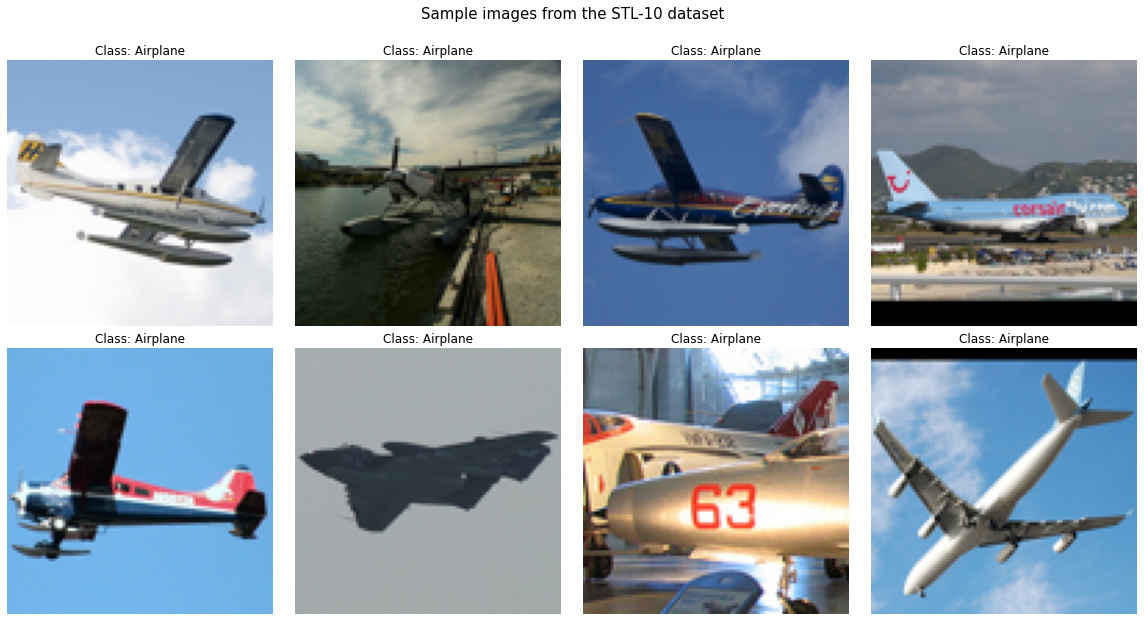

In [7]:
train_data._show_samples("images", indices)

### SIFT features

In [26]:
clf = BoWClassifier(TRAIN_X_PATH, TRAIN_y_PATH)

::::::::: Loaded dataset with images ((5000, 96, 96, 3)) and labels ((5000,)) ::::::::::


Extracting image features with SIFT: 100%|██████████| 5000/5000 [00:09<00:00, 540.76it/s]                                                   


In [27]:
clf.train_data.data.keys()

dict_keys(['images', 'labels', 'indices', 'kps', 'des', 'images_with_kps'])

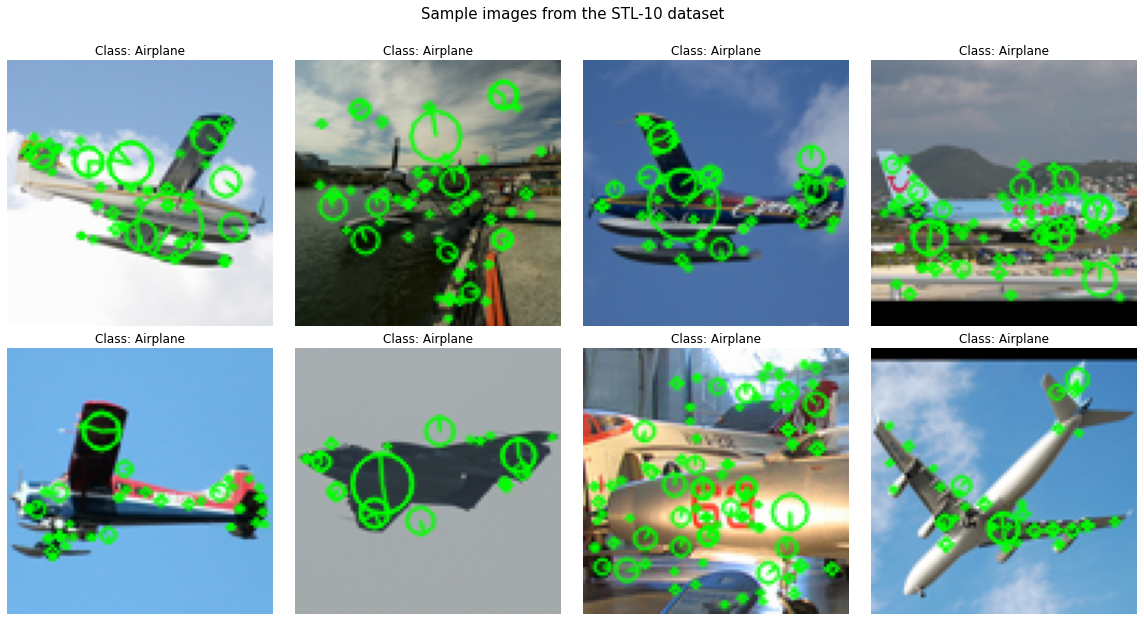

In [10]:
clf.train_data._show_samples("images_with_kps", indices)

### Clustering

In [11]:
clustering_indices, ftencoding_indices = clf.split_train_data(clf.train_data)

In [12]:
kmeans, X = clf.cluster_descriptors(clf.train_data, clustering_indices, n_clusters=500)

::::: Finished K-Means on visual descriptors of size (93075, 128) in 202.09338426589966 secs.


In [185]:
cluster_centers.shape

(500, 128)

In [15]:
X = np.vstack(clf.train_data._get_samples_by_indices("des", clustering_indices))

cluster_ids = kmeans[0].predict(X)
cluster_centers = kmeans[0].cluster_centers_

cluster_centers.shape

(500, 128)

In [16]:
def visualize_clusters(
        descriptors, cluster_labels, cluster_centers,
        viz_clusters=25, num_samples=10000, total_clusters=500, seed=0
    ):
    np.random.seed(seed)

    tsne = TSNE(n_components=2, random_state=seed)
    indices = np.random.randint(0, len(descriptors), num_samples)
    selected_clusters = np.random.randint(0, total_clusters, size=viz_clusters)
    mu = cluster_centers[selected_clusters]

    X = descriptors[indices]
    y = cluster_labels[indices]
    X_ = np.vstack([X, mu])
    
    y_ = np.concatenate([y, selected_clusters])
    Z = tsne.fit_transform(X_)

    df = pd.DataFrame(None, columns=["Z1", "Z2", "cluster_label", "style"])
    df["Z1"] = Z[:, 0]
    df["Z2"] = Z[:, 1]
    df["cluster_label"] = y_
    df["style"] = ["circle" for i in range(len(X))] + ["cross" for i in range(len(X), len(Z))]

    subdf = df[df["cluster_label"].apply(lambda x: x in selected_clusters)]

    fig, ax = plt.subplots(1, 1, figsize=(11, 7))
    ax.grid()
    sns.scatterplot(
        data=subdf,
        x="Z1", y="Z2", hue="cluster_label", palette="Set2", legend=False, ax=ax, s=100, style="style",
    )
    ax.scatter(
        x=Z[len(X):, 0], y=Z[len(X):, 1], marker="x", s=100, c="black", label="Cluster centers"
    )
    ax.set_title(
        f"Randomly selected {viz_clusters} clusters (out of {total_clusters}) visualized via TSNE embeddings."
    )
    
    plt.legend()
    plt.savefig(f"./results/random_{viz_clusters}_{total_clusters}_clusters.png", bbox_inches="tight")
    plt.show()

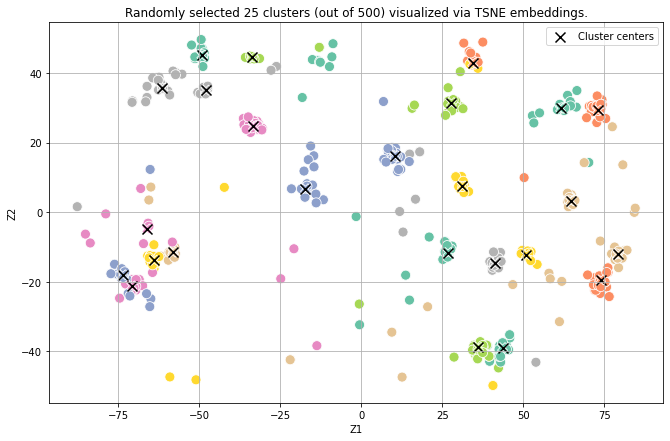

In [17]:
visualize_clusters(X, cluster_ids, cluster_centers)

### Computing frequency-based features for remaining training set

In [32]:
X2 = clf.train_data._get_samples_by_indices("des", ftencoding_indices)
X2 = np.vstack(X2)

In [33]:
cluster_ids = kmeans[0].predict(X2)

In [34]:
cluster_ids

array([158, 275,   7, ..., 101,  37, 466], dtype=int32)

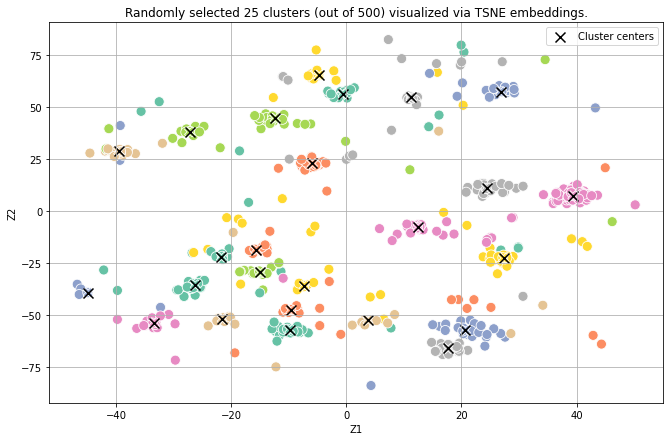

In [36]:
visualize_clusters(X2, cluster_ids, cluster_centers)

### Construct visual dictionary

In [37]:
from sklearn.neighbors import NearestNeighbors

In [38]:
nearest_ngbr_predictor = NearestNeighbors(n_neighbors=1).fit(cluster_centers)

In [59]:
ftencoding_images = clf.train_data._get_samples_by_indices("images", ftencoding_indices)
ftencoding_images = np.array(ftencoding_images)

ftencoding_labels = clf.train_data._get_samples_by_indices("labels", ftencoding_indices)
ftencoding_labels = np.array(ftencoding_labels)

In [60]:
ftencoding_images.shape, ftencoding_labels

((1550, 96, 96, 3), array([1, 1, 1, ..., 3, 3, 3], dtype=uint8))

In [45]:
X2.shape

(116309, 128)

In [61]:
ftencoding_features = np.zeros((len(ftencoding_indices), 500))

for j, i in tqdm(enumerate(ftencoding_indices), desc="Encoding features"):
    image_desc = clf.train_data.data["des"][i]

    if image_desc is not None:
        distances, words = nearest_ngbr_predictor.kneighbors(image_desc)

        for w in words:
            ftencoding_features[j, w] += 1.0 / len(words)

Encoding features: 1550it [00:01, 953.16it/s]


In [62]:
np.sum(ftencoding_features)

1548.9999999999995

In [65]:
ftencoding_features.max(), ftencoding_features.min(), ftencoding_features.shape

(0.375, 0.0, (1550, 500))

In [72]:
# visualize image features

tsne = PCA(n_components=2, random_state=0)
X = ftencoding_features
Z = tsne.fit_transform(X)
y = ftencoding_labels

<AxesSubplot:xlabel='Z1', ylabel='Z2'>

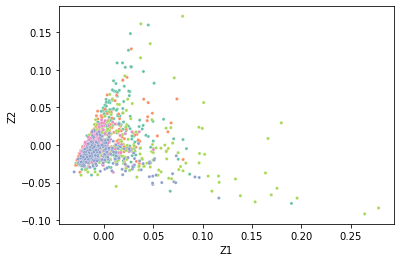

In [73]:
df = pd.DataFrame(None)
df["Z1"] = Z[:, 0]
df["Z2"] = Z[:, 1]
df["label"] = y

sns.scatterplot(
    data=df,
    x="Z1", y="Z2", hue="label", palette="Set2", legend=False, s=10,
)

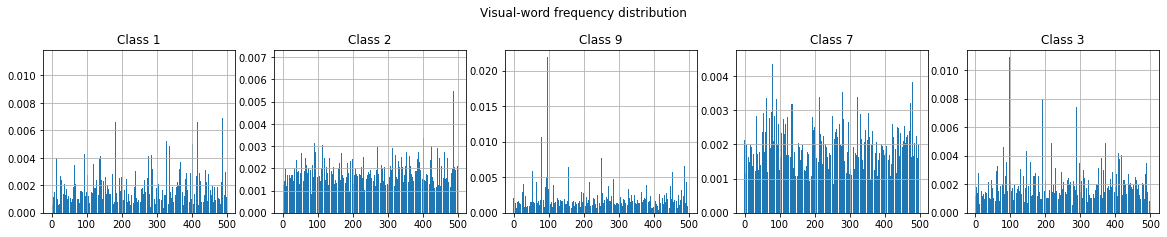

In [181]:
fig, axes = plt.subplots(1, len(relevant_classes), figsize=(20, 3))

for j, i in enumerate(relevant_classes):
    ax = axes[j]

    ax.grid()

    x = list(range(ftencoding_features.shape[1]))
    height = ftencoding_features[ftencoding_labels == i]
    height = np.mean(height, axis=0)

    ax.bar(x, height)
    ax.set_title(f"Class {i}")

plt.suptitle("Visual-word frequency distribution", y=1.08)
plt.show()

In [155]:
ftencoding_features.shape, \
ftencoding_labels.shape

((1550, 500), (1550,))

In [156]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score as AP
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [170]:
svm = SVC(C=1.0, probability=True)
ovr = OneVsRestClassifier(estimator=svm)
pipe = Pipeline([('ovr', ovr)])

In [171]:
pipe.fit(ftencoding_features, ftencoding_labels)

Pipeline(steps=[('ovr', OneVsRestClassifier(estimator=SVC(probability=True)))])

In [172]:
y_pred = ovr.predict(ftencoding_features)
y_pred_proba = ovr.predict_proba(ftencoding_features)

In [173]:
y_pred.shape, y_pred_proba.shape

((1550,), (1550, 5))

In [174]:
np.unique(y_pred)

array([1, 2, 3, 7, 9], dtype=uint8)

In [175]:
ohe = OneHotEncoder()
y_pred_onehot = ohe.fit_transform(y_pred.reshape((-1, 1))).toarray()

In [176]:
y_pred_onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [177]:
y_pred

array([1, 1, 1, ..., 3, 3, 3], dtype=uint8)

In [178]:
(ftencoding_labels == 2).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [179]:
mAP = 0.0
for j, i in enumerate(relevant_classes):
    mAP += AP((ftencoding_labels == i).astype(int), y_pred_onehot[:, j]) / 5.0

In [180]:
mAP

0.6533275960557012

### Evaluate on the test set

In [127]:
TEST_X_PATH = join(DATA_DIR, "test_X.bin")
TEST_y_PATH = join(DATA_DIR, "test_y.bin")

In [128]:
test_data = STL(TEST_X_PATH, TEST_y_PATH)

::::::::: Loaded dataset with images ((8000, 96, 96, 3)) and labels ((8000,)) ::::::::::


In [129]:
test_data.data = clf.extract_features(clf.SIFT, test_data.data)

Extracting image features with SIFT: 100%|██████████| 8000/8000 [00:15<00:00, 509.86it/s]                                                   


In [207]:
# use entire test set
# test_indices = list(range(len(test_data.data["images"])))
test_indices = test_data._sample_by_attribute("labels", relevant_classes)

In [208]:
test_images = test_data._get_samples_by_indices("images", test_indices)
test_images = np.array(test_images)

test_labels = test_data._get_samples_by_indices("labels", test_indices)
test_labels = np.array(test_labels)

In [209]:
test_features.max(), test_features.min()

(0.75, 0.0)

In [210]:
len(test_images), len(test_labels)

(4000, 4000)

In [211]:
test_features = np.zeros((len(test_indices), 500))

for j, i in tqdm(enumerate(test_indices), desc="Encoding features"):
    image_desc = test_data.data["des"][i]

    if image_desc is not None:
        distances, words = nearest_ngbr_predictor.kneighbors(image_desc)

        for w in words:
            test_features[j, w] += 1.0 / len(words)

Encoding features: 4000it [00:04, 903.04it/s]


In [212]:
test_features.shape

(4000, 500)

In [213]:
y_pred = ovr.predict(test_features)
y_pred_proba = ovr.predict_proba(test_features)

ohe = OneHotEncoder()
y_pred_onehot = ohe.fit_transform(y_pred.reshape((-1, 1))).toarray()

In [214]:
y_pred_proba

array([[0.23450149, 0.12435493, 0.35644028, 0.12823711, 0.1564662 ],
       [0.29628241, 0.22883002, 0.05961475, 0.04247469, 0.37279814],
       [0.01078763, 0.32686974, 0.01703061, 0.58011227, 0.06519975],
       ...,
       [0.41759543, 0.25606887, 0.0259656 , 0.02935813, 0.27101197],
       [0.11012479, 0.09020624, 0.32553073, 0.12315849, 0.35097975],
       [0.13904323, 0.08637883, 0.11516595, 0.31065744, 0.34875455]])

In [215]:
np.unique(test_labels)

array([1, 2, 3, 7, 9], dtype=uint8)

In [227]:
mAP = 0.0
per_class_AP = dict()

for j, i in enumerate(relevant_classes):
    class_ap = AP((test_labels == i).astype(int), y_pred_proba[:, j])
    mAP += class_ap / len(relevant_classes)
    per_class_AP[idx_to_class[i]] = class_ap

per_class_AP["average"] = mAP

In [228]:
per_class_AP

{'airplane': 0.6321238617330659,
 'bird': 0.5019268912960042,
 'ship': 0.18570740106659273,
 'horse': 0.6128232908391559,
 'car': 0.1633962412757985,
 'average': 0.41919553724212344}

In [229]:
mAP

0.41919553724212344

In [219]:
y_pred

array([3, 9, 7, ..., 1, 3, 9], dtype=uint8)

In [200]:
test_labels

array([7, 8, 6, ..., 9, 9, 9], dtype=uint8)

In [220]:
accuracy_score(test_labels, y_pred)

0.55075